# Feature Engineering and Logistic Regression

# Introduction

Here I will create feature variables for use with the logistic regression model to create a baseline performance for predicting CTR on Google AdWords data.

# Load Processed Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import pandas as pd
train_data = pd.read_csv('../data/raw/train_data_no_text.csv', 
                        parse_dates=['Date'])

In [3]:
train_data.head()

,Unnamed: 0,Ad ID,Ad group ID,Campaign ID,Keyword ID,Search term match type,Date,Day of week,Device,Quality score,...,Landing page experience,Avg. position,Impressions,Clicks,Cost,Conversions,click_target,ctr,Month,Day of Month
0,0,240574173525,46423626238,908117249,296868692064,Broad,2018-03-26,Monday,Mobile,--,...,--,2.0,1,0,0.00,0.0,0,0.0,3,26
1,1,217160772198,47045144564,908117249,347502862051,Exact,2017-09-01,Friday,Mobile,--,...,--,2.0,1,0,0.00,0.0,0,0.0,9,1
2,2,240574173525,46423626238,908117249,296868692064,Phrase,2018-04-30,Monday,Mobile,--,...,--,3.0,1,0,0.00,0.0,0,0.0,4,30
3,3,357859796080,53253585965,1376132377,442183914904,Exact,2019-07-05,Friday,Mobile,9,...,Above average,1.0,1,1,0.38,0.5,1,1.0,7,5
4,4,314179203506,53253584085,1376048789,354206717502,Exact,2019-07-06,Saturday,Desktop,9,...,Above average,1.0,1,1,0.27,0.0,1,1.0,7,6


In [4]:
train_data.columns

Index(['Unnamed: 0', 'Ad ID', 'Ad group ID', 'Campaign ID', 'Keyword ID',
       'Search term match type', 'Date', 'Day of week', 'Device',
       'Quality score', 'Expected clickthrough rate', 'Ad relevance',
       'Keyword max CPC', 'First position CPC', 'Top of page CPC',
       'Landing page experience', 'Avg. position', 'Impressions', 'Clicks',
       'Cost', 'Conversions', 'click_target', 'ctr', 'Month', 'Day of Month'],
      dtype='object')

In [5]:
# for drop text based features
train_data.drop(columns=['Unnamed: 0', 'Ad group ID', 'Conversions'], inplace=True)

In [6]:
train_data.head()

,Ad ID,Campaign ID,Keyword ID,Search term match type,Date,Day of week,Device,Quality score,Expected clickthrough rate,Ad relevance,...,Top of page CPC,Landing page experience,Avg. position,Impressions,Clicks,Cost,click_target,ctr,Month,Day of Month
0,240574173525,908117249,296868692064,Broad,2018-03-26,Monday,Mobile,--,--,--,...,0.80,--,2.0,1,0,0.00,0,0.0,3,26
1,217160772198,908117249,347502862051,Exact,2017-09-01,Friday,Mobile,--,--,--,...,0.35,--,2.0,1,0,0.00,0,0.0,9,1
2,240574173525,908117249,296868692064,Phrase,2018-04-30,Monday,Mobile,--,--,--,...,0.80,--,3.0,1,0,0.00,0,0.0,4,30
3,357859796080,1376132377,442183914904,Exact,2019-07-05,Friday,Mobile,9,Above average,Average,...,0.14,Above average,1.0,1,1,0.38,1,1.0,7,5
4,314179203506,1376048789,354206717502,Exact,2019-07-06,Saturday,Desktop,9,Above average,Average,...,0.12,Above average,1.0,1,1,0.27,1,1.0,7,6


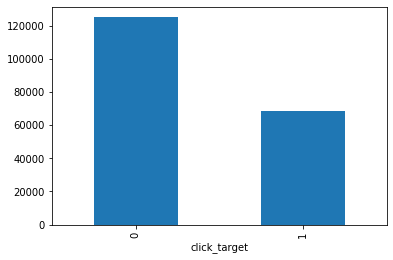

In [7]:
# a quick glance at class balance
train_data.groupby('click_target').size().plot(kind = 'bar')

There is class imbalance this will ned to tbe fixed before modelling

# Pre-Processing

In [8]:
# check for any NaN
print(train_data.isna().values.sum())

0


## Create new features from time


In [9]:
train_data['Day of Year'] = train_data['Date'].dt.dayofyear
train_data['Week of Year'] = train_data['Date'].dt.week
train_data['Day of Week'] = train_data['Date'].dt.dayofweek
# drop redundant string version of day
train_data.drop(columns='Day of week', inplace=True)

### Remove all NaN 

In [10]:
# take one value for sense checking
train_data.head()

,Ad ID,Campaign ID,Keyword ID,Search term match type,Date,Device,Quality score,Expected clickthrough rate,Ad relevance,Keyword max CPC,...,Impressions,Clicks,Cost,click_target,ctr,Month,Day of Month,Day of Year,Week of Year,Day of Week
0,240574173525,908117249,296868692064,Broad,2018-03-26,Mobile,--,--,--,0.80,...,1,0,0.00,0,0.0,3,26,85,13,0
1,217160772198,908117249,347502862051,Exact,2017-09-01,Mobile,--,--,--,0.80,...,1,0,0.00,0,0.0,9,1,244,35,4
2,240574173525,908117249,296868692064,Phrase,2018-04-30,Mobile,--,--,--,0.80,...,1,0,0.00,0,0.0,4,30,120,18,0
3,357859796080,1376132377,442183914904,Exact,2019-07-05,Mobile,9,Above average,Average,0.51,...,1,1,0.38,1,1.0,7,5,186,27,4
4,314179203506,1376048789,354206717502,Exact,2019-07-06,Desktop,9,Above average,Average,0.60,...,1,1,0.27,1,1.0,7,6,187,27,5


### Replace '--' in AdWords Data with NaN

In [11]:
# replace '--' with NaN
train_data = train_data.replace({'--': np.nan}, regex=True)

In [12]:
# remove all entries with NaN
train_data = train_data.dropna()

In [13]:
# check for any NaN
print(train_data.isna().values.sum())

0


In [14]:
# take one value for sense checking
train_data.head()

,Ad ID,Campaign ID,Keyword ID,Search term match type,Date,Device,Quality score,Expected clickthrough rate,Ad relevance,Keyword max CPC,...,Impressions,Clicks,Cost,click_target,ctr,Month,Day of Month,Day of Year,Week of Year,Day of Week
3,357859796080,1376132377,442183914904,Exact,2019-07-05,Mobile,9,Above average,Average,0.51,...,1,1,0.38,1,1.000000,7,5,186,27,4
4,314179203506,1376048789,354206717502,Exact,2019-07-06,Desktop,9,Above average,Average,0.60,...,1,1,0.27,1,1.000000,7,6,187,27,5
8,314179203965,1376133520,315359911820,Broad,2019-07-07,Tablet,8,Above average,Below average,0.51,...,2,0,0.00,0,0.000000,7,7,188,27,6
9,357859796818,1376524026,443040648236,Phrase,2019-07-17,Mobile,8,Above average,Below average,0.17,...,1,1,0.07,1,1.000000,7,17,198,29,2
11,314179203962,1376133520,441743760160,Broad,2019-07-17,Mobile,8,Above average,Below average,0.51,...,3,2,0.67,1,0.666667,7,17,198,29,2


## Create category data

In [15]:
# create category df
cat_df = train_data.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

In [16]:
# remove object columns
train_data_obj = train_data.select_dtypes(exclude=['object'])

In [17]:
# concat new cat columns
train_data = pd.concat([train_data_obj, cat_df], axis=1)

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118563 entries, 3 to 194263
Data columns (total 24 columns):
Ad ID                         118563 non-null int64
Campaign ID                   118563 non-null int64
Keyword ID                    118563 non-null int64
Date                          118563 non-null datetime64[ns]
Keyword max CPC               118563 non-null float64
First position CPC            118563 non-null float64
Top of page CPC               118563 non-null float64
Avg. position                 118563 non-null float64
Impressions                   118563 non-null int64
Clicks                        118563 non-null int64
Cost                          118563 non-null float64
click_target                  118563 non-null int64
ctr                           118563 non-null float64
Month                         118563 non-null int64
Day of Month                  118563 non-null int64
Day of Year                   118563 non-null int64
Week of Year                  118563

In [19]:
train_data.size

2845512

In [20]:
train_data.reset_index(inplace=True)

In [21]:
train_data.drop(columns=['index'], inplace=True)

In [22]:
train_data.head()

,Ad ID,Campaign ID,Keyword ID,Date,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,...,Day of Month,Day of Year,Week of Year,Day of Week,Search term match type,Device,Quality score,Expected clickthrough rate,Ad relevance,Landing page experience
0,357859796080,1376132377,442183914904,2019-07-05,0.51,0.75,0.14,1.00,1,1,...,5,186,27,4,Exact,Mobile,9,Above average,Average,Above average
1,314179203506,1376048789,354206717502,2019-07-06,0.60,0.12,0.12,1.00,1,1,...,6,187,27,5,Exact,Desktop,9,Above average,Average,Above average
2,314179203965,1376133520,315359911820,2019-07-07,0.51,0.34,0.18,1.00,2,0,...,7,188,27,6,Broad,Tablet,8,Above average,Below average,Above average
3,357859796818,1376524026,443040648236,2019-07-17,0.17,0.34,0.06,1.00,1,1,...,17,198,29,2,Phrase,Mobile,8,Above average,Below average,Above average
4,314179203962,1376133520,441743760160,2019-07-17,0.51,0.37,0.31,1.33,3,2,...,17,198,29,2,Broad,Mobile,8,Above average,Below average,Above average


In [23]:
# select these cat columns for later
categorical_columns = list(train_data.select_dtypes(['category']).columns)

In [24]:
categorical_columns

['Search term match type',
 'Device',
 'Quality score',
 'Expected clickthrough rate',
 'Ad relevance',
 'Landing page experience']

### Ordinal Data Encoding

In [25]:
from category_encoders.ordinal import OrdinalEncoder

`Quality score`, `Expected clickthrough rate`, `Ad relevance` and `Landing page experience` are all categorical variables that should be encoded as ordered data. The values have inherent information in relation to each other

In [31]:
ordinal_categorical_columns = categorical_columns[2:]

In [34]:
one_hot_categorical_columns = list(categorical_columns[i] for i in [0, 1] )

In [35]:
one_hot_categorical_columns

['Search term match type', 'Device']

In [36]:
ordinal_categorical_columns

['Quality score',
 'Expected clickthrough rate',
 'Ad relevance',
 'Landing page experience']

In [38]:
ordinal_col_mapping = [{
    "col": "Quality score",
    "mapping": {
        '10': 6,
        '9': 5,
        '8': 4,
        '7': 3,
        '6': 2,
        '5': 1,
        '4': 0
    }}, {
    "col": "Expected clickthrough rate",
    "mapping": {
        'Above average': 1,
        'Average': 0
    }},
    {
    "col": "Ad relevance",
    "mapping": {
        'Above average': 2,
        'Average': 1,
        'Below average': 0
    }},
    {
    "col": "Landing page experience",
    "mapping": {
        'Above average': 2,
        'Average': 1,
        'Below average': 0
    }}
] 

In [39]:
# create encoder instance
ord_enc = OrdinalEncoder(cols=categorical_columns, mapping=ordinal_col_mapping, return_df=True)
ord_enc

OrdinalEncoder(cols=['Search term match type', 'Device', 'Quality score',
                     'Expected clickthrough rate', 'Ad relevance',
                     'Landing page experience'],
               drop_invariant=False, handle_missing='value',
               handle_unknown='value',
               mapping=[{'col': 'Quality score',
                         'mapping': {'10': 6, '4': 0, '5': 1, '6': 2, '7': 3,
                                     '8': 4, '9': 5}},
                        {'col': 'Expected clickthrough rate',
                         'mapping': {'Above average': 1, 'Average': 0}},
                        {'col': 'Ad relevance',
                         'mapping': {'Above average': 2, 'Average': 1,
                                     'Below average': 0}},
                        {'col': 'Landing page experience',
                         'mapping': {'Above average': 2, 'Average': 1,
                                     'Below average': 0}}],
               return_df=

### Create New Transformed DF

In [82]:
# fit ordinal encoding and tranform
df_train = ord_enc.fit_transform(train_data)
df_train.head()

,Ad ID,Campaign ID,Keyword ID,Date,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,...,Day of Month,Day of Year,Week of Year,Day of Week,Search term match type,Device,Quality score,Expected clickthrough rate,Ad relevance,Landing page experience
0,357859796080,1376132377,442183914904,2019-07-05,0.51,0.75,0.14,1.00,1,1,...,5,186,27,4,Exact,Mobile,5,1,1,2
1,314179203506,1376048789,354206717502,2019-07-06,0.60,0.12,0.12,1.00,1,1,...,6,187,27,5,Exact,Desktop,5,1,1,2
2,314179203965,1376133520,315359911820,2019-07-07,0.51,0.34,0.18,1.00,2,0,...,7,188,27,6,Broad,Tablet,4,1,0,2
3,357859796818,1376524026,443040648236,2019-07-17,0.17,0.34,0.06,1.00,1,1,...,17,198,29,2,Phrase,Mobile,4,1,0,2
4,314179203962,1376133520,441743760160,2019-07-17,0.51,0.37,0.31,1.33,3,2,...,17,198,29,2,Broad,Mobile,4,1,0,2


In [83]:
df_train.columns

Index(['Ad ID', 'Campaign ID', 'Keyword ID', 'Date', 'Keyword max CPC',
       'First position CPC', 'Top of page CPC', 'Avg. position', 'Impressions',
       'Clicks', 'Cost', 'click_target', 'ctr', 'Month', 'Day of Month',
       'Day of Year', 'Week of Year', 'Day of Week', 'Search term match type',
       'Device', 'Quality score', 'Expected clickthrough rate', 'Ad relevance',
       'Landing page experience'],
      dtype='object')

### One-Hot Encoding

In [84]:
# get dummies encoding                                                                      
df_train = pd.concat([df_train, pd.get_dummies(df_train[one_hot_categorical_columns])], axis=1)

In [85]:
# drop transformed columns
df_train.drop(columns=one_hot_categorical_columns, inplace=True)

In [86]:
df_train.columns

Index(['Ad ID', 'Campaign ID', 'Keyword ID', 'Date', 'Keyword max CPC',
       'First position CPC', 'Top of page CPC', 'Avg. position', 'Impressions',
       'Clicks', 'Cost', 'click_target', 'ctr', 'Month', 'Day of Month',
       'Day of Year', 'Week of Year', 'Day of Week', 'Quality score',
       'Expected clickthrough rate', 'Ad relevance', 'Landing page experience',
       'Search term match type_Broad', 'Search term match type_Exact',
       'Search term match type_Phrase', 'Device_Desktop', 'Device_Mobile',
       'Device_Tablet'],
      dtype='object')

## Cyclical Encoding of Time

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:

$x_{sin} = \sin(\frac{2 * \pi * x}{\max(x)})$

$x_{cos} = \cos(\frac{2 * \pi * x}{\max(x)})$

Let's do this for the time components that are cyclical

In [87]:
# check dtypes before continuing
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118563 entries, 0 to 118562
Data columns (total 28 columns):
Ad ID                            118563 non-null int64
Campaign ID                      118563 non-null int64
Keyword ID                       118563 non-null int64
Date                             118563 non-null datetime64[ns]
Keyword max CPC                  118563 non-null float64
First position CPC               118563 non-null float64
Top of page CPC                  118563 non-null float64
Avg. position                    118563 non-null float64
Impressions                      118563 non-null int64
Clicks                           118563 non-null int64
Cost                             118563 non-null float64
click_target                     118563 non-null int64
ctr                              118563 non-null float64
Month                            118563 non-null int64
Day of Month                     118563 non-null int64
Day of Year                      118563 non

In [88]:
# encoding cyclical features
df_train['day_of_week_sin'] = np.sin(df_train['Day of Week'])*(2.*np.pi/7)
df_train['day_of_week_cos'] = np.cos(df_train['Day of Week'])*(2.*np.pi/7)
df_train['month_sin'] = np.sin((df_train['Month']-1)*(2.*np.pi/12))
df_train['month_cos'] = np.cos((df_train['Month']-1)*(2.*np.pi/12))
df_train['day_of_year_sin'] = np.sin((df_train['Day of Year']-1)*(2.*np.pi/365))
df_train['day_of_year_cos'] = np.cos((df_train['Day of Year']-1)*(2.*np.pi/365))
# date or day of month is a potential to investigate later ie. 31, 26 etc

In [89]:
# after this we can drop the Date column as it will not be used
df_train.drop(columns='Date', inplace=True)

In [90]:
# preview data once more
df_train.head()

,Ad ID,Campaign ID,Keyword ID,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,Cost,...,Search term match type_Phrase,Device_Desktop,Device_Mobile,Device_Tablet,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,357859796080,1376132377,442183914904,0.51,0.75,0.14,1.00,1,1,0.38,...,0,0,1,0,-0.679304,-0.586709,1.224647e-16,-1.0,-0.043022,-0.999074
1,314179203506,1376048789,354206717502,0.60,0.12,0.12,1.00,1,1,0.27,...,0,1,0,0,-0.860728,0.254615,1.224647e-16,-1.0,-0.060213,-0.998186
2,314179203965,1376133520,315359911820,0.51,0.34,0.18,1.00,2,0,0.00,...,0,0,0,1,-0.250803,0.861847,1.224647e-16,-1.0,-0.077386,-0.997001
3,357859796818,1376524026,443040648236,0.17,0.34,0.06,1.00,1,1,0.07,...,1,0,1,0,0.816183,-0.373533,1.224647e-16,-1.0,-0.247022,-0.969010
4,314179203962,1376133520,441743760160,0.51,0.37,0.31,1.33,3,2,0.67,...,0,0,1,0,0.816183,-0.373533,1.224647e-16,-1.0,-0.247022,-0.969010


In [91]:
# how many campaigns are in here?
df_train['Campaign ID'].unique().size

8

### Removing Irrelevant Variables

Future work will use the textual based columns to retrieve word embeddings and use Word2Vec algorithms to enable them as features

In [114]:
df_train.head()

,Ad ID,Campaign ID,Keyword ID,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,Cost,...,Search term match type_Phrase,Device_Desktop,Device_Mobile,Device_Tablet,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,357859796080,1376132377,442183914904,0.51,0.75,0.14,1.00,1,1,0.38,...,0,0,1,0,-0.679304,-0.586709,1.224647e-16,-1.0,-0.043022,-0.999074
1,314179203506,1376048789,354206717502,0.60,0.12,0.12,1.00,1,1,0.27,...,0,1,0,0,-0.860728,0.254615,1.224647e-16,-1.0,-0.060213,-0.998186
2,314179203965,1376133520,315359911820,0.51,0.34,0.18,1.00,2,0,0.00,...,0,0,0,1,-0.250803,0.861847,1.224647e-16,-1.0,-0.077386,-0.997001
3,357859796818,1376524026,443040648236,0.17,0.34,0.06,1.00,1,1,0.07,...,1,0,1,0,0.816183,-0.373533,1.224647e-16,-1.0,-0.247022,-0.969010
4,314179203962,1376133520,441743760160,0.51,0.37,0.31,1.33,3,2,0.67,...,0,0,1,0,0.816183,-0.373533,1.224647e-16,-1.0,-0.247022,-0.969010


In [115]:
df_train.columns

Index(['Ad ID', 'Campaign ID', 'Keyword ID', 'Keyword max CPC',
       'First position CPC', 'Top of page CPC', 'Avg. position', 'Impressions',
       'Clicks', 'Cost', 'click_target', 'ctr', 'Month', 'Day of Month',
       'Day of Year', 'Week of Year', 'Day of Week', 'Quality score',
       'Expected clickthrough rate', 'Ad relevance', 'Landing page experience',
       'Search term match type_Broad', 'Search term match type_Exact',
       'Search term match type_Phrase', 'Device_Desktop', 'Device_Mobile',
       'Device_Tablet', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

In [116]:
df_train.drop(columns=['Ad ID','Campaign ID', 'Keyword ID', 'ctr'], inplace=True)

In [117]:
df_train.head()

,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,Cost,click_target,Month,Day of Month,...,Search term match type_Phrase,Device_Desktop,Device_Mobile,Device_Tablet,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,0.51,0.75,0.14,1.00,1,1,0.38,1,7,5,...,0,0,1,0,-0.679304,-0.586709,1.224647e-16,-1.0,-0.043022,-0.999074
1,0.60,0.12,0.12,1.00,1,1,0.27,1,7,6,...,0,1,0,0,-0.860728,0.254615,1.224647e-16,-1.0,-0.060213,-0.998186
2,0.51,0.34,0.18,1.00,2,0,0.00,0,7,7,...,0,0,0,1,-0.250803,0.861847,1.224647e-16,-1.0,-0.077386,-0.997001
3,0.17,0.34,0.06,1.00,1,1,0.07,1,7,17,...,1,0,1,0,0.816183,-0.373533,1.224647e-16,-1.0,-0.247022,-0.969010
4,0.51,0.37,0.31,1.33,3,2,0.67,1,7,17,...,0,0,1,0,0.816183,-0.373533,1.224647e-16,-1.0,-0.247022,-0.969010


# Getting Data Ready for Modelling

In [ ]:
# stratify
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
RNG = 42
# Make some synthetic imbalanced binary classification data
X, y = make_classification(n_classes=2, class_sep=2, 
	weights=[0.95, 0.05], 
	n_informative=2, n_redundant=5, 
	flip_y=0.05, n_features=50, 
	n_clusters_per_class=1, 
	n_samples=1000, random_state=RNG)

metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=3)
scv = StratifiedKFold(n_splits=3)
clf = GaussianNB()
for metric in metric_names:
    score1 = cross_val_score(clf, X, y, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(clf, X, y, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]

In [141]:
# Separate input features and target
y = df_train.click_target
X = df_train.drop('click_target', axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [142]:
print("Number records X_train dataset: ", X_train.shape)
print("Number records y_train dataset: ", y_train.shape)
print("Number records X_test dataset: ", X_test.shape)
print("Number records y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (88922, 28)
Number transactions y_train dataset:  (88922,)
Number transactions X_test dataset:  (29641, 28)
Number transactions y_test dataset:  (29641,)


In [143]:
# Show the class distribution in each label set
def get_class_dist(data, name):
    unique, counts = np.unique(data, return_counts=True)
    pct = 100*(counts/len(data))
    d = dict(zip(unique, zip(counts, pct)))
    print(len(data), 'total examples in %s' % name)
    for key, values in d.items():
        print('class %d: %d examples,' % (key, values[0]), "{0:.2f}%".format(values[1]))
    print('')
    return

get_class_dist(data=y_train, name='y_train')
get_class_dist(data=y_test, name='y_test')

88922 total examples in y_train
class 0: 53668 examples, 60.35%
class 1: 35254 examples, 39.65%

29641 total examples in y_test
class 0: 18273 examples, 61.65%
class 1: 11368 examples, 38.35%



## Correcting Class Imbalance

It is important to perform class balancing on **only the training data**. As shown earlier the entries that are clicked are far less then those that are un-clicked and therefore will not produce a good logistic regression baseline.

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

### Upsampling

In [118]:
from sklearn.utils import resample
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [122]:
# separate minority and majority classes
not_clicked = X[X.click_target==0]
clicked = X[X.click_target==1]

# up sample minority
clicked_upsampled = resample(clicked,
                          replace=True, # sample with replacement
                          n_samples=len(not_clicked), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_clicked, clicked_upsampled])

# check new class counts
upsampled.click_target.value_counts()

1    53668
0    53668
Name: click_target, dtype: int64

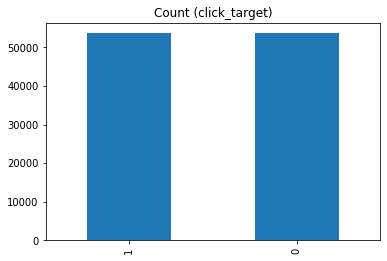

In [129]:
upsampled.click_target.value_counts().plot(kind='bar', title='Count (click_target)');

In [134]:
upsampled.size

3112744

### Down sampling

Doing the opposite to experiment to find the best results for the logistic regression

In [123]:
# still using our separated classes clicked and not_clicked from above
# down sample majority
not_click_downsampled = resample(not_clicked,
                                replace = False, # sample without replacement
                                n_samples = len(clicked), # match minority n
                                random_state = 42) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_click_downsampled, clicked])

# checking counts
downsampled.click_target.value_counts()

1    35254
0    35254
Name: click_target, dtype: int64

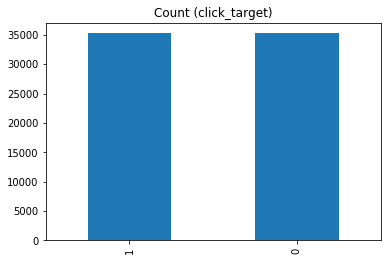

In [130]:
downsampled.click_target.value_counts().plot(kind='bar', title='Count (click_target)');

### SMOTE Resampling

In [138]:
from imblearn.over_sampling import SMOTE

In [146]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))
get_class_dist(data=y_train_res, name='y_train_res')

Before OverSampling, counts of label '1': 35254
Before OverSampling, counts of label '0': 53668 

After OverSampling, the shape of train_X: (107336, 28)
After OverSampling, the shape of train_y: (107336,) 

After OverSampling, counts of label '1': 53668
After OverSampling, counts of label '0': 53668 

107336 total examples in y_train_res
class 0: 53668 examples, 50.00%
class 1: 53668 examples, 50.00%



In [127]:
# create plotting function
def plot_2d_space(X, y, label='click_target'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, alpha=0.3
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

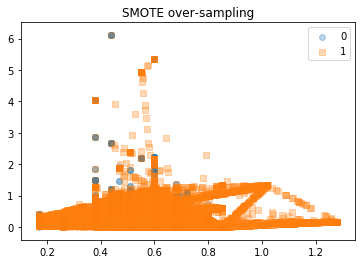

In [145]:
# plot the new resampling
plot_2d_space(X_train_res, y_train_res, 'SMOTE over-sampling')

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

## Not Correcting Imbalance

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y), y)

# Feature Selection

In [ ]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load the iris dataset
dataset = datasets.load_iris()
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(dataset.data, dataset.target)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# load the iris datasets
dataset = datasets.load_iris()
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(dataset.data, dataset.target)
# display the relative importance of each attribute
print(model.feature_importances_)

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.4)
data_test, data_val = train_test_split(data_test, test_size=0.5)


# Standardization 

In [ ]:
# Standardise and normalise
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.33, random_state=42)

# Evaluation Metrics

Change the performance metric

As we saw above, accuracy is not the best metric to use when evaluating imbalanced datasets as it can be very misleading. Metrics that can provide better insight include:
1. Confusion Matrix: a table showing correct predictions and types of incorrect predictions.

2. Precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
3. Recall: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
4. F1: Score: the weighted average of precision and recall.

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

### F1-score as a fucntion of regularization (penalty) parameter

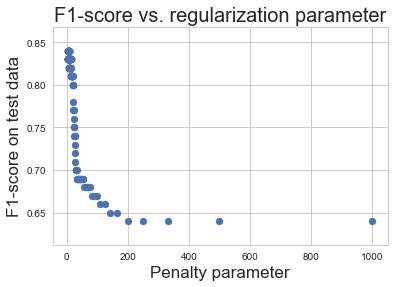

In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
nsimu=201
penalty=[0]*nsimu
logmodel=[0]*nsimu
predictions =[0]*nsimu
class_report = [0]*nsimu
f1=[0]*nsimu
for i in range(1,nsimu):
        logmodel[i] =(LogisticRegression(C=i/1000,tol=1e-4, max_iter=100,n_jobs=4))
        logmodel[i].fit(X_train,y_train)
        predictions[i] = logmodel[i].predict(X_test)
        class_report[i] = classification_report(y_test,predictions[i])
        l=class_report[i].split()
        f1[i] = l[len(l)-2]
        penalty[i]=1000/i

plt.scatter(penalty[1:len(penalty)-2],f1[1:len(f1)-2])
plt.title("F1-score vs. regularization parameter",fontsize=20)
plt.xlabel("Penalty parameter",fontsize=17)
plt.ylabel("F1-score on test data",fontsize=17)
plt.show()

### F1-score as a function of test set size (fraction)

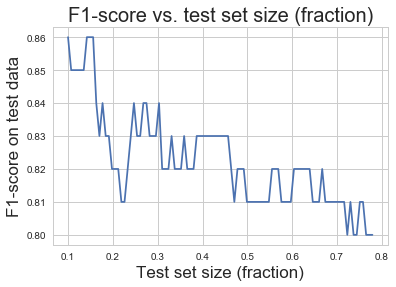

In [197]:
nsimu=101
class_report = [0]*nsimu
f1=[0]*nsimu
test_fraction =[0]*nsimu
for i in range(1,nsimu):
        X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.1+(i-1)*0.007, 
                                                    random_state=111)
        logmodel =(LogisticRegression(C=1,tol=1e-4, max_iter=1000,n_jobs=4))
        logmodel.fit(X_train,y_train)
        predictions = logmodel.predict(X_test)
        class_report[i] = classification_report(y_test,predictions)
        l=class_report[i].split()
        f1[i] = l[len(l)-2]
        test_fraction[i]=0.1+(i-1)*0.007

plt.plot(test_fraction[1:len(test_fraction)-2],f1[1:len(f1)-2])
plt.title("F1-score vs. test set size (fraction)",fontsize=20)
plt.xlabel("Test set size (fraction)",fontsize=17)
plt.ylabel("F1-score on test data",fontsize=17)
plt.show()